In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#
from sklearn.model_selection import train_test_split
# Методы для масштабирования признаков
from sklearn.preprocessing import StandardScaler #, MinMaxScaler
# Модель линейной регрессии
from sklearn.linear_model import LinearRegression
# Модель лассо-регрессии с кросс-валидацией (L1-регуляризация)
from sklearn.linear_model import LassoCV
# Модель ридж-регрессии с кросс-валидацией (L2-регуляризация)
from sklearn.linear_model import RidgeCV
# Модель эластичная сеть (L1 и L2 регуляризация)
from sklearn.linear_model import ElasticNetCV
# MAE и MSE метрики для оценки работы обученной модели
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

In [2]:
# Загрузить данные в DataFrame из csv-файла
df = pd.read_csv('AB_NYC_2019_MY.csv')
df.sample(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
31544,Queens,309,40.77496,-73.91172,Private room,60,15,12,0.85,1,21
33578,Manhattan,2655,40.82763,-73.94404,Private room,63,1,19,7.92,2,16
10257,Manhattan,1540,40.75709,-73.96972,Entire home/apt,299,2,7,0.15,1,0


In [3]:
# Получить только текстовые колонки из DataFrame'a
myObjectDf = df.select_dtypes(include='object')

# Получить все колонки исключая текстовые из DataFrame'a
myNumericDf = df.select_dtypes(exclude='object')

# Создать из категориальных переменных Dummy переменные (one hot encoding)
myDummiesDf = pd.get_dummies(myObjectDf, drop_first=True)

for col in myDummiesDf.columns:
    tmp = myDummiesDf[col].apply(int)
    myDummiesDf[col] = tmp

finalDf = pd.concat([myNumericDf, myDummiesDf], axis='columns')
#finalDf.info()

In [4]:
# Признаки - Features
X = finalDf.drop('price', axis='columns')
# Целевая переменная
y = finalDf['price']

# Разбить набор данных на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [5]:
# Создать объект для масштабирования признаков
standardScaler = StandardScaler()

# На основе анализа ТОЛЬКО тренировочных признаков,
# подготовить объект к масштабированию признаков
standardScaler.fit(X_train)  # ВАЖНО! В этот метод передаем только тренировочный набор признаков

# Масштабирование тренировочных признаков
# mean = 0; std = 1
X_scaled_train = standardScaler.transform(X_train)
#print(X_scaled_train.mean(), X_scaled_train.std(), end='\n\n');

# Масштабирование тестовых признаков
# mean = 0; std = 1
X_scaled_test = standardScaler.transform(X_test)
#print(X_scaled_test.mean(), X_scaled_test.std(), end='\n\n');
X_scaled_train.shape, y_train.shape

((33954, 14), (33954,))

In [6]:
# Создать объект модели обучения
linearRegressionModel = LinearRegression()
# Обучить модель
linearRegressionModel.fit(X_scaled_train, y_train)
# Вычислить целевые переменные, на основе обученной модели
yPredict = linearRegressionModel.predict(X_scaled_test)
#yPredict

In [7]:
# Среднее значение целевой переменной
yMean = df['price'].mean()

In [8]:
# Оценки (метрики)

# Mean Absolute Error (MAE) - средняя абсолютная ошибка
mae = mean_absolute_error(y_test, yPredict)
print(f'mae = {mae}', end='\n\n')

# Mean Squared Error (MSE) - среднеквадратическая ошибка
mse = mean_squared_error(y_test, yPredict)
print(f'mse = {mse}', end='\n\n')

# Root Mean Square Error (RMSE) - среднеквадратическое отклонение
rmse = np.sqrt(mse)
print(f'rmse = {rmse}', end='\n\n')
percent = int( np.around(rmse/yMean*100, 0) )
print(f'rmse процент от yMean = {percent}%')

mae = 66.98051617489463

mse = 21284.6716523241

rmse = 145.89267168821092

rmse процент от yMean = 99%


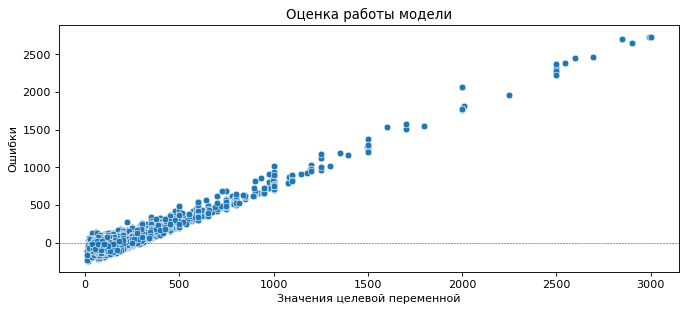

In [9]:
# Остатки (ошибки работы модели)
testResiduals = y_test - yPredict

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=80)
# Строим график рассеяния ошибок относительно 0
# Основной график для оценивания остатков
sns.scatterplot(x=y_test, y=testResiduals)
#
axes.set_title('Оценка работы модели')
axes.set_xlabel('Значения целевой переменной')
axes.set_ylabel('Ошибки')
# Нарисовать нулевую линию по оси Y
axes.axhline(y=0, color='#FF0000', linestyle='--', linewidth=0.5);

In [10]:
# Создать объект модели обучения
lassoCvModel = LassoCV(
    # Число, на основе которого вычисляется диапазон для значений лямбда-параметров
    # eps = alphaMin / alphaMax
    eps=0.001,
    # Количество лямбда-параметров для L1-регуляризации,
    # которые будут проверятся методом кросс-валидации
    n_alphas=100,
    cv=5,
    max_iter=1000000
)

# Обучить модель
lassoCvModel.fit(X_scaled_train, y_train)
#print(lassoCvModel.coef_, end='\n\n')

# Какое значение лямбда, по мнению модели L1-регуляризации, является наилучшим
alphaBest = lassoCvModel.alpha_
print(f'alphaBest = {alphaBest}', end='\n\n')

# Вычислить целевые переменные, на основе обученной модели
yPredict = lassoCvModel.predict(X_scaled_test)
#yPredict

alphaBest = 0.05418161225328911



In [11]:
# Оценки (метрики)

# Mean Absolute Error (MAE) - средняя абсолютная ошибка
mae = mean_absolute_error(y_test, yPredict)
print(f'mae = {mae}', end='\n\n')

# Mean Squared Error (MSE) - среднеквадратическая ошибка
mse = mean_squared_error(y_test, yPredict)
print(f'mse = {mse}', end='\n\n')

# Root Mean Square Error (RMSE) - среднеквадратическое отклонение
rmse = np.sqrt(mse)
print(f'rmse = {rmse}', end='\n\n')
percent = int( np.around(rmse/yMean*100, 0) )
print(f'rmse процент от yMean = {percent}%')

mae = 66.93953723610817

mse = 21284.161640261016

rmse = 145.89092377615893

rmse процент от yMean = 99%


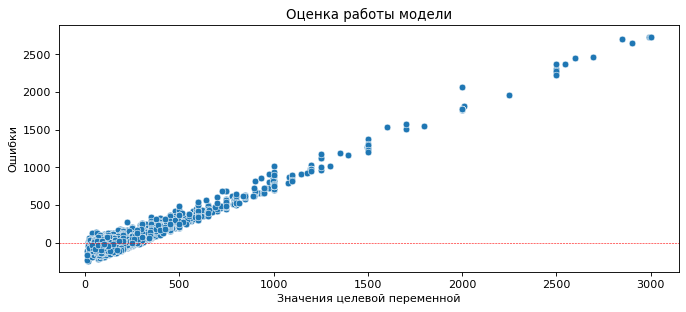

In [12]:
# Остатки (ошибки работы модели)
testResiduals = y_test - yPredict

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=80)
# Строим график рассеяния ошибок относительно 0
# Основной график для оценивания остатков
sns.scatterplot(x=y_test, y=testResiduals)
#
axes.set_title('Оценка работы модели')
axes.set_xlabel('Значения целевой переменной')
axes.set_ylabel('Ошибки')
# Нарисовать нулевую линию по оси Y
axes.axhline(y=0, color='#FF0000', linestyle='--', linewidth=0.5);

In [13]:
# Создать объект модели обучения
ridgeCvModel = RidgeCV(
    # Список лямбда-параметров для L2-регуляризации,
    # которые будут проверятся методом кросс-валидации
    alphas=(0.01, 0.05, 0.1, 0.15, 0.2, 1.0, 5.0, 10.0),
    cv=5,
    # Метрика, по которой будет выбираться наилучший результат
    # Здесь выбрали: Root Mean Square Error (RMSE) - среднеквадратическое отклонение
    scoring=('neg_root_mean_squared_error')
)

# Обучить модель
ridgeCvModel.fit(X_scaled_train, y_train)

# Какое значение лямбда, по мнению модели L2-регуляризации, является наилучшим
alphaBest = ridgeCvModel.alpha_
print(f'alphaBest = {alphaBest}'); print()

# Вычислить целевые переменные, на основе обученной модели
yPredict = ridgeCvModel.predict(X_scaled_test)
#yPredict

alphaBest = 10.0



In [14]:
# Оценки (метрики)

# Mean Absolute Error (MAE) - средняя абсолютная ошибка
mae = mean_absolute_error(y_test, yPredict)
print(f'mae = {mae}', end='\n\n')

# Mean Squared Error (MSE) - среднеквадратическая ошибка
mse = mean_squared_error(y_test, yPredict)
print(f'mse = {mse}', end='\n\n')

# Root Mean Square Error (RMSE) - среднеквадратическое отклонение
rmse = np.sqrt(mse)
print(f'rmse = {rmse}', end='\n\n')
percent = int( np.around(rmse/yMean*100, 0) )
print(f'rmse процент от yMean = {percent}%')

mae = 66.97603238709344

mse = 21284.580746276148

rmse = 145.89236013676708

rmse процент от yMean = 99%


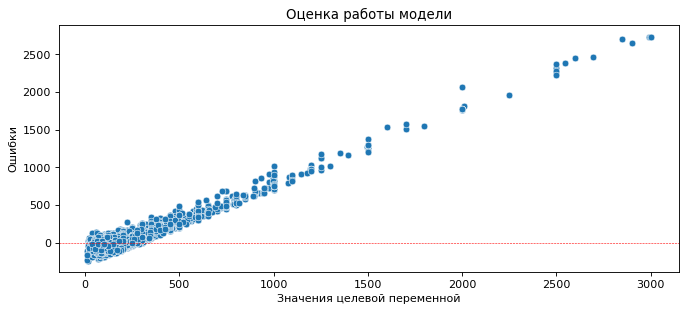

In [15]:
testResiduals = y_test - yPredict

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=80)
# Строим график рассеяния ошибок относительно 0
# Основной график для оценивания остатков
sns.scatterplot(x=y_test, y=testResiduals)
#
axes.set_title('Оценка работы модели')
axes.set_xlabel('Значения целевой переменной')
axes.set_ylabel('Ошибки')
# Нарисовать нулевую линию по оси Y
axes.axhline(y=0, color='#FF0000', linestyle='--', linewidth=0.5);

In [16]:
# Создать объект модели обучения
elasticCvModel = ElasticNetCV(
    # Соотношение между L1 и L2 в Elastic Net (L1 и L2 регуляризация)
    # l1_ratio=0.5,
    # Или список, из которого будет выбираться наилучшее значение
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    # Число, на основе которого вычисляется диапазон для значений лямбда-параметров
    # eps = alphaMin / alphaMax
    eps=0.001,
    # Количество лямбда-параметров для Elastic Net,
    # которые будут проверятся методом кросс-валидации
    n_alphas=100,
    cv=5,
    max_iter=1000000
)

# Обучить модель
elasticCvModel.fit(X_scaled_train, y_train)
#print(elasticCvModel.coef_, end='\n\n')

# Какое значение альфа, по мнению модели L1иL2-регуляризации, является наилучшим
alphaBest = elasticCvModel.l1_ratio_
print(f'alphaBest = {alphaBest}', end='\n\n')
# Какое значение лямбда, по мнению модели L1иL2-регуляризации, является наилучшим
lambdaBest = elasticCvModel.alpha_
print(f'lambdaBest = {lambdaBest}', end='\n\n')

# Вычислить целевые переменные, на основе обученной модели
yPredict = elasticCvModel.predict(X_scaled_test)
#yPredict

alphaBest = 1.0

lambdaBest = 0.05418161225328911



In [17]:
# Оценки (метрики)

# Mean Absolute Error (MAE) - средняя абсолютная ошибка
mae = mean_absolute_error(y_test, yPredict)
print(f'mae = {mae}', end='\n\n')

# Mean Squared Error (MSE) - среднеквадратическая ошибка
mse = mean_squared_error(y_test, yPredict)
print(f'mse = {mse}', end='\n\n')

# Root Mean Square Error (RMSE) - среднеквадратическое отклонение
rmse = np.sqrt(mse)
print(f'rmse = {rmse}', end='\n\n')
percent = int( np.around(rmse/yMean*100, 0) )
print(f'rmse процент от yMean = {percent}%')

mae = 66.93953723610817

mse = 21284.161640261016

rmse = 145.89092377615893

rmse процент от yMean = 99%


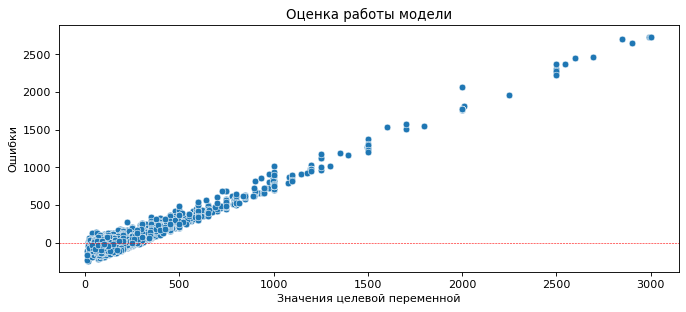

In [18]:
testResiduals = y_test - yPredict

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=80)
# Строим график рассеяния ошибок относительно 0
# Основной график для оценивания остатков
sns.scatterplot(x=y_test, y=testResiduals)
#
axes.set_title('Оценка работы модели')
axes.set_xlabel('Значения целевой переменной')
axes.set_ylabel('Ошибки')
# Нарисовать нулевую линию по оси Y
axes.axhline(y=0, color='#FF0000', linestyle='--', linewidth=0.5);

In [19]:
# Разные модели линейной регресси не влияют на точность работы